# Open-weight model experiment

Run the open-weight model comparison on the consensus dataset without relying on local data files. The notebook pulls the data directly from GitHub, loads any available API keys from env files next to the notebook, and saves results locally to a CSV.


In [1]:
# Install dependencies
! pip install -q pfd_toolkit ipywidgets

In [8]:
# Get API key

import os
from ipywidgets import Password, Button, VBox, HTML

api_key_input = Password(
    description="API key:",
    placeholder="Paste your key here"
)
status = HTML("")
button = Button(description="Set key")

def set_api_key(_):
    if api_key_input.value:
        os.environ["OPENAI_API_KEY"] = api_key_input.value
        # clear the visible value
        api_key_input.value = ""
        status.value = "<b>API key stored in this session.</b>"
    else:
        status.value = "<b>No key entered.</b>"

button.on_click(set_api_key)

ui = VBox([api_key_input, button, status])
ui


In [9]:
api_key = os.environ["OPENAI_API_KEY"]

In [10]:
from pathlib import Path
import shutil
import os
import tempfile
from urllib.parse import quote

import pandas as pd
from dotenv import load_dotenv
import requests

from pfd_toolkit import LLM, Screener
from pfd_toolkit.config import GeneralConfig

NOTEBOOK_DIR = Path.cwd()


from getpass import getpass

def ensure_secret(env_name: str) -> str:
    if env_name not in os.environ or not os.environ[env_name]:
        os.environ[env_name] = getpass(f"Enter {env_name}: ")
    return os.environ[env_name]

OPENAI_API_KEY = api_key

GITHUB_BASE = "https://raw.githubusercontent.com/Sam-Osian/PFD-toolkit/open-model-exp"
DATA_URL = f"{GITHUB_BASE}/ons_replication/{quote('PFD Toolkit--Consensus Comparison.xlsx')}"
SHEET_NAME = "Consensus annotations"
RESULTS_PATH = NOTEBOOK_DIR / "model_comparison.csv"


## Start Ollama in Colab

Install and start the Ollama daemon locally so the open-weight models can be downloaded and served within this runtime.

In [11]:

import shutil
import subprocess
import time

import requests

OLLAMA_PORT = 11434
OLLAMA_BASE_URL = f"http://localhost:{OLLAMA_PORT}/v1"

if not shutil.which("ollama"):
    print("Installing Ollama...")
    !curl -fsSL https://ollama.com/install.sh | sh

# Start the Ollama server if it isn't already running
try:
    requests.get(f"http://localhost:{OLLAMA_PORT}/api/tags", timeout=2)
    print("Ollama is already running.")
except Exception:
    print("Starting ollama serve...")
    ollama_process = subprocess.Popen(
        ["ollama", "serve"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
    )
    for _ in range(60):
        try:
            requests.get(f"http://localhost:{OLLAMA_PORT}/api/tags", timeout=2)
            print("Ollama is ready.")
            break
        except Exception:
            time.sleep(1)
    else:
        raise RuntimeError("Ollama failed to start. Check the logs above.")


Ollama is already running.


In [12]:

OLLAMA_MODELS = [
    {"name": "mistral-nemo:12b", "temperature": 0, "timeout": 10**9},
    #{"name": "mistral-small:22b", "temperature": 0, "timeout": 10**9},
    #{"name": "mistral-small:24b", "temperature": 0, "timeout": 10**9},
]

for spec in OLLAMA_MODELS:
    print(f"Pulling {spec['name']} (this may take a few minutes)...")
    subprocess.run(["ollama", "pull", spec["name"]], check=True)


Pulling mistral-nemo:12b (this may take a few minutes)...


In [13]:

data_path = Path(tempfile.gettempdir()) / "pfd_toolkit_consensus.xlsx"
response = requests.get(DATA_URL, timeout=60)
response.raise_for_status()
data_path.write_bytes(response.content)

print(f"Dataset downloaded to {data_path}")

df = pd.read_excel(data_path, sheet_name=SHEET_NAME)
consensus_column_name = "Post-consensus verdict: Is this a child suicide case? (Yes or No)"

raw_consensus = df[consensus_column_name]
raw_values = raw_consensus.dropna().astype(str).str.strip()
print("Unique raw consensus values:")
for value in sorted(raw_values.unique()):
    print(f"- {value}")

renamed = df.rename(
    columns={
        "Ref": GeneralConfig.COL_ID,
        "Investigation section": GeneralConfig.COL_INVESTIGATION,
        "Circumstances of death section": GeneralConfig.COL_CIRCUMSTANCES,
        "Matters of concern section": GeneralConfig.COL_CONCERNS,
        consensus_column_name: "consensus",
    }
)

reports = renamed[
    [
        GeneralConfig.COL_ID,
        GeneralConfig.COL_INVESTIGATION,
        GeneralConfig.COL_CIRCUMSTANCES,
        GeneralConfig.COL_CONCERNS,
        "consensus",
    ]
].copy()

normalized_consensus = reports["consensus"].astype(str).str.strip().str.lower()
print("Normalised consensus values before boolean conversion:")
for value in sorted(normalized_consensus.unique()):
    print(f"- {value}")

reports["consensus"] = normalized_consensus == "yes"
print("Boolean consensus values after conversion:")
print(sorted(reports["consensus"].unique().tolist()))

reports.head()


Dataset downloaded to /tmp/pfd_toolkit_consensus.xlsx
Unique raw consensus values:
- No
- Yes
Normalised consensus values before boolean conversion:
- no
- yes
Boolean consensus values after conversion:
[False, True]


,id,investigation,circumstances,concerns,consensus
0,2023-0452,On 12 August 2022 I commenced an investigation...,Madeleine Savory was 15 years old when they di...,"The availability, nationally, of Tier 4 beds i...",True
1,2023-0445,"On 15 May 2023, one of my assistant coroners, ...",Igor hanged himself in his room at the Depaul ...,"On 28 March 2023, Igor refused to get out of t...",True
2,2023-0313,On 3 August 2022 I commenced an investigation ...,Allison Aules was referred to the mental healt...,The Inquest identified multiple failings in th...,True
3,2023-0283,On 12 June 2019 I commenced an investigation i...,NaN,A detailed review of the evidence in this case...,True
4,2023-0146,On 31 August 2022 I opened an investigation to...,On 27 August 2022 Callum Wong was found having...,1. Consideration for exceptions to patient con...,True


In [14]:

MODEL_SPECS = [
    # OpenAI API models
    {"name": "gpt-4.1", "temperature": 0},
    {"name": "gpt-4.1-mini", "temperature": 0},
    {"name": "gpt-4.1-nano", "temperature": 0},
]

# Append Ollama-hosted models using the shared base URL and API key
MODEL_SPECS += [
    {
        "name": spec["name"],
        "temperature": spec["temperature"],
        "base_url": OLLAMA_BASE_URL,
        "api_key": "ollama",
        "timeout": spec.get("timeout", 20),
    }
    for spec in OLLAMA_MODELS
]

user_query = """
Identify cases where the deceased was aged 18 or younger *clearly at the time of death* **and**
the death was due to suicide. If suicide is not explicitly stated, you can use a strict balance of
probabilities threshold to determine it as such.

Age may not be explicitly stated, but could be implied through references such as
recent use of child or adolescent services (e.g. CAMHS), attending school years
(e.g. "Year 10"), or similar contextual indicators of being under 18 (again, under a
strict balance of probabilities threshold).
"""


In [16]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
from adjustText import adjust_text

results_columns = ["model", "accuracy", "sensitivity", "specificity", "elapsed_seconds"]
if RESULTS_PATH.exists():
    results_df = pd.read_csv(RESULTS_PATH)
    for col in results_columns:
        if col not in results_df:
            results_df[col] = pd.NA
else:
    results_df = pd.DataFrame(columns=results_columns)

completed_models = set(results_df["model"].astype(str))

for spec in MODEL_SPECS:
    if spec["name"] in completed_models:
        print(f"Skipping {spec['name']} (already evaluated)")
        continue

    print(f"Testing model: {spec['name']}")

    start_time = time.perf_counter()

    llm_client = LLM(
        api_key=spec.get("api_key", os.getenv("OPENAI_API_KEY")),
        base_url=spec.get("base_url"),
        max_workers=8,
        model=spec["name"],
        seed=12345,
        timeout=spec.get("timeout", 20),
        temperature=1 if spec["name"].startswith("gpt-5") else spec["temperature"],
    )

    screener = Screener(
        llm=llm_client,
        reports=reports,
        include_investigation=True,
        include_circumstances=True,
        include_concerns=True,
    )

    classified = screener.screen_reports(
        search_query=user_query,
        filter_df=False,
        result_col_name="model_pred",
    )

    elapsed_seconds = time.perf_counter() - start_time

    pred = classified["model_pred"].astype(bool)
    truth = classified["consensus"].astype(bool)

    tp = (pred & truth).sum()
    tn = ((~pred) & (~truth)).sum()
    fp = (pred & ~truth).sum()
    fn = ((~pred) & truth).sum()

    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total else float("nan")
    sensitivity = tp / (tp + fn) if (tp + fn) else float("nan")
    specificity = tn / (tn + fp) if (tn + fp) else float("nan")

    results_df = pd.concat(
        [
            results_df,
            pd.DataFrame(
                [
                    {
                        "model": spec["name"],
                        "accuracy": accuracy,
                        "sensitivity": sensitivity,
                        "specificity": specificity,
                        "elapsed_seconds": elapsed_seconds,
                    }
                ]
            ),
        ],
        ignore_index=True,
    )

    results_df.to_csv(RESULTS_PATH, index=False)
    completed_models.add(spec["name"])

    if spec.get("base_url") == OLLAMA_BASE_URL:
        print(f"Removing Ollama model {spec['name']} to free space...")
        subprocess.run(["ollama", "rm", spec["name"]], check=False)

results_df



Skipping gpt-4.1 (already evaluated)
Skipping gpt-4.1-mini (already evaluated)
Skipping gpt-4.1-nano (already evaluated)
Skipping mistral-nemo:12b (already evaluated)


,model,accuracy,sensitivity,specificity,elapsed_seconds
0,gpt-4.1,0.910959,0.897059,0.923077,<NA>
1,gpt-4.1-mini,0.917808,0.911765,0.923077,<NA>
2,gpt-4.1-nano,0.904110,0.941176,0.871795,<NA>
3,mistral-nemo:12b,0.904110,0.838235,0.961538,<NA>


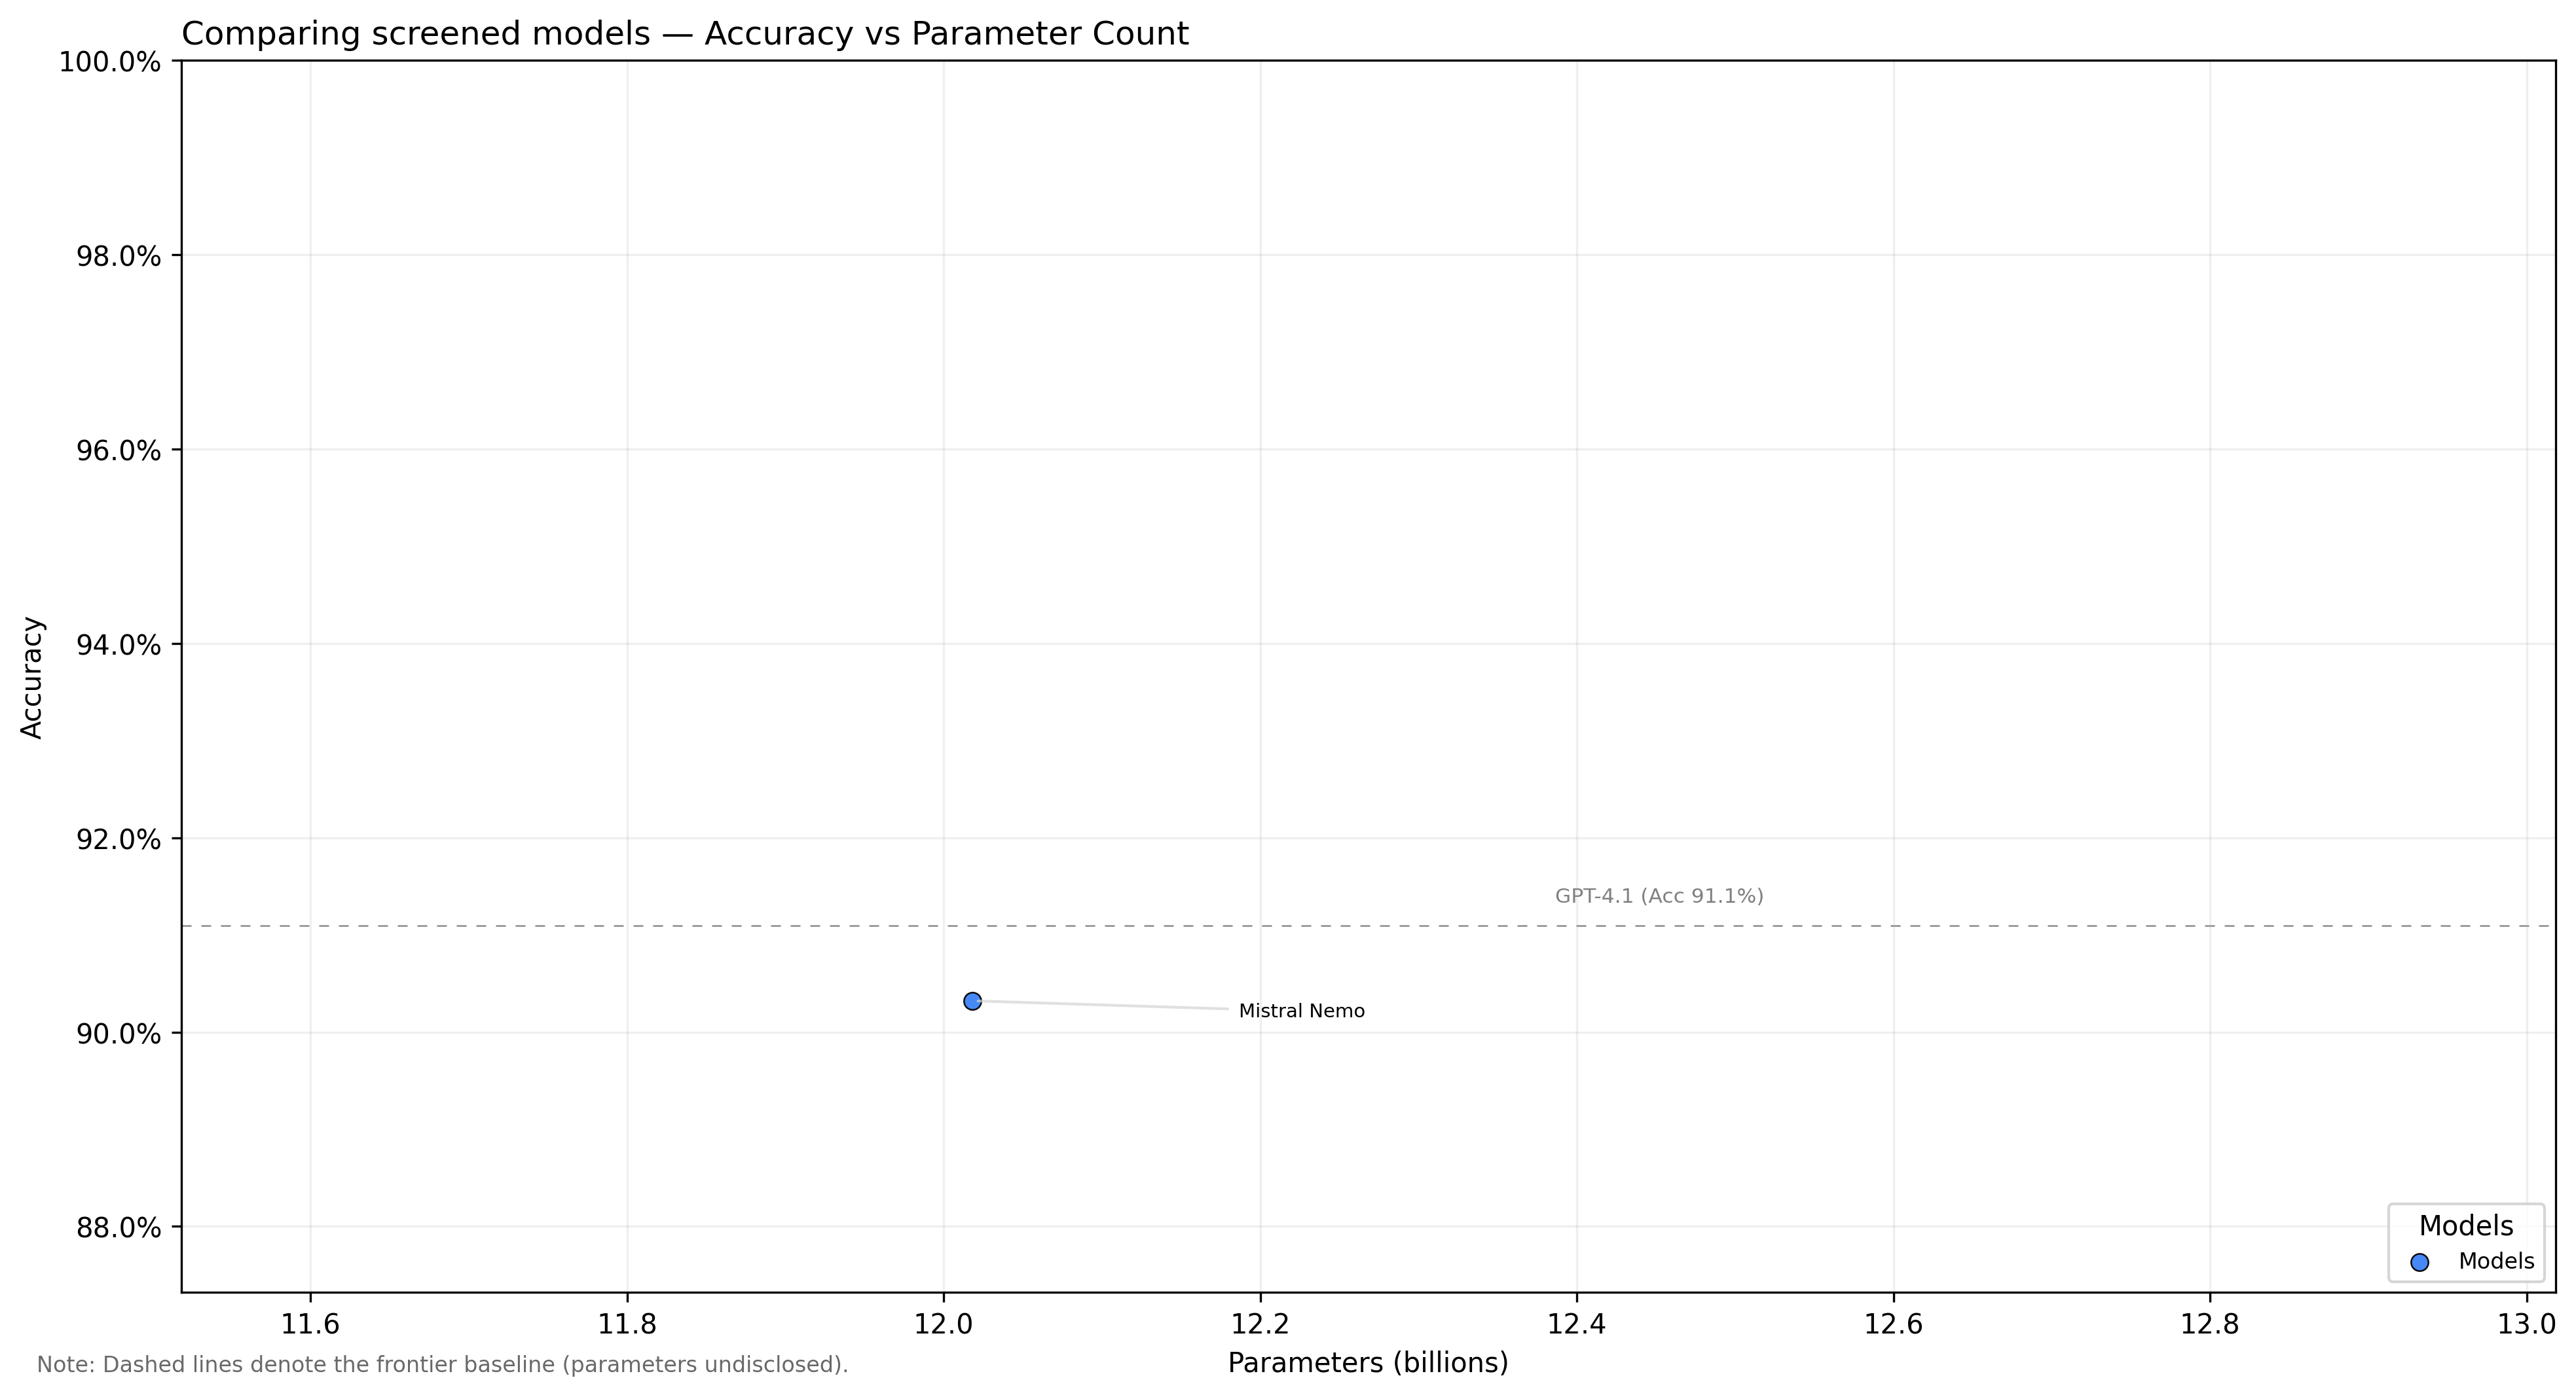

In [18]:
plot_df = results_df.copy()
plot_df["accuracy"] = pd.to_numeric(plot_df["accuracy"], errors="coerce")

PARAMS_BILLIONS = {
    "google/gemma-3-4b-it": 4,
    "google/gemma-3-12b-it": 12,
    "mistral-nemo:12b": 12,
    "mistral-small:22b": 22,
    "mistral-small:24b": 24,
    "gemma3:12b": 12,
    "gemma3:27b": 27,
    "gemma2:27b": 27,
    "qwen3:32b": 32,
    "qwen3:30b": 30,
    "qwen2.5:72b": 72,
    "qwen2.5:32b": 32,
    "llava:34b": 34,
    "phi4:14b": 14,
    "llama3:70b": 70,
}

plot_df["params_billion"] = plot_df["model"].map(PARAMS_BILLIONS)
plot_df = plot_df.dropna(subset=["accuracy"])

# Styling borrowed from tests/model_comparison_vis.py
X_PAD_RIGHT = 1.0
X_MIN_PAD = 0.5
INIT_DX = 0.4
INIT_DY = 0.0

JITTER_X = 0.05
JITTER_Y = 0.001

EXP_TEXT = (1.02, 1.55)
EXP_POINTS = (1.05, 1.20)
FORCE_TEXT = 1
FORCE_POINTS = 0.4
N_STEPS = 1000

ARROW = dict(arrowstyle='-', color='lightgray', lw=1, alpha=0.7)

BLUE = "#3B82F6"
GREEN = "#10B981"
EDGE = "black"

SHORT_LABELS = {
    "mistralai/devstral-small": "DevStral Small",
    "mistralai/mistral-large-2411": "Mistral Large",
    "google/gemma-3-4b-it": "Gemma 3 (4B)",
    "deepseek/deepseek-chat-v3-0324": "DeepSeek v3",
    "moonshotai/kimi-k2": "Kimi K2",
    "qwen/qwen3-235b-a22b-2507": "Qwen3 A22B",
    "meta-llama/llama-4-maverick": "Llama 4 Mav.",
    "mistral-nemo:12b": "Mistral Nemo",
    "mistral-small:22b": "Mistral Small (22B)",
    "mistral-small:24b": "Mistral Small (24B)",
    "gemma3:12b": "Gemma 3 (12B)",
    "gemma3:27b": "Gemma 3 (27B)",
    "gemma2:27b": "Gemma 2 (27B)",
    "qwen3:32b": "Qwen3 (32B)",
    "qwen3:30b": "Qwen3 (30B)",
    "qwen2.5:72b": "Qwen 2.5 (72B)",
    "qwen2.5:32b": "Qwen 2.5 (32B)",
    "llava:34b": "LLaVA",
    "phi4:14b": "Phi-4",
    "llama3:70b": "Llama 3",
    "google/gemma-3-12b-it": "Gemma 3 (12B)",
    "cohere/command-a": "Command A",
    "mistralai/codestral-2508": "Codestral",
    "gpt-4.1": "GPT-4.1",
    "gpt-4.1-mini": "GPT-4.1 mini",
    "gpt-4.1-nano": "GPT-4.1 nano",
}

FRONTIER_NAMES = {"gpt-4.1": "GPT-4.1"}

# Split frontier vs plotted models
frontier_df = plot_df[plot_df["model"].isin(FRONTIER_NAMES)].copy()
scatter_df = plot_df[~plot_df["model"].isin(FRONTIER_NAMES)].copy()
scatter_df = scatter_df.dropna(subset=["params_billion"])

if scatter_df.empty and frontier_df.empty:
    print("No results available to plot yet.")
else:
    rng = np.random.default_rng(123)
    scatter_df["params_jit"] = scatter_df["params_billion"] + rng.uniform(-JITTER_X, JITTER_X, size=len(scatter_df))
    scatter_df["accuracy_jit"] = scatter_df["accuracy"] + rng.uniform(-JITTER_Y, JITTER_Y, size=len(scatter_df))

    fig, ax = plt.subplots(figsize=(13, 7), dpi=300, constrained_layout=True)

    sc_points = None
    if not scatter_df.empty:
        sc_points = ax.scatter(
            scatter_df["params_jit"],
            scatter_df["accuracy_jit"],
            s=40,
            zorder=2,
            facecolor=BLUE,
            edgecolor=EDGE,
            linewidth=0.6,
            alpha=0.95,
            label="Models",
        )

    texts = []
    for i, r in scatter_df.reset_index(drop=True).iterrows():
        label = SHORT_LABELS.get(str(r["model"]), str(r["model"]))
        dx = INIT_DX
        dy = (1 if (i % 2 == 0) else -1) * (INIT_DY * (1.0 + 0.3 * rng.random()))
        ann = ax.annotate(
            label,
            xy=(r["params_jit"], r["accuracy_jit"]),
            xytext=(r["params_jit"] + dx, r["accuracy_jit"] + dy),
            textcoords="data",
            ha="left",
            va="center",
            fontsize=7,
            color="black",
            arrowprops=ARROW,
        )
        texts.append(ann)

    ax.set_xlabel("Parameters (billions)")
    ax.set_ylabel("Accuracy")
    ax.grid(True, alpha=0.2)
    ax.set_title(
        "Comparing screened models — Accuracy vs Parameter Count",
        loc="left",
    )

    x_min = max(0.0, float(scatter_df["params_jit"].min()) - X_MIN_PAD) if not scatter_df.empty else 0.0
    x_max = float(scatter_df["params_jit"].max()) + X_PAD_RIGHT if not scatter_df.empty else 1.0
    y_min = max(0.0, float(scatter_df["accuracy_jit"].min()) - 0.03) if not scatter_df.empty else 0.0
    y_max = 1.0
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    if not frontier_df.empty:
        for _, r in frontier_df.iterrows():
            ax.axhline(r["accuracy"], color="grey", lw=0.6, ls=(0, (6, 6)), zorder=1, alpha=0.9)
            ax.text(
                x_max - 0.5,
                r["accuracy"] + 0.002,
                f"{FRONTIER_NAMES[r['model']]} (Acc {r['accuracy']*100:.1f}%)",
                ha="right",
                va="bottom",
                fontsize=7.5,
                color="grey",
            )

    add_objs = [h for h in [sc_points] if h is not None]
    adjust_text(
        texts,
        ax=ax,
        add_objects=add_objs,
        expand_text=EXP_TEXT,
        expand_points=EXP_POINTS,
        force_text=FORCE_TEXT,
        force_points=FORCE_POINTS,
        only_move={"points": "y", "text": "xy"},
        autoalign=True,
        precision=0.01,
        lim=N_STEPS,
    )

    if add_objs:
        ax.legend(loc="lower right", frameon=True, fontsize=8, title="Models")

    ax.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=1))

    fig.text(
        0.01,
        0.01,
        "Note: Dashed lines denote the frontier baseline (parameters undisclosed).",
        fontsize=8,
        color="dimgray",
    )

    fig

